<a href="https://colab.research.google.com/github/prog815/portfOptim/blob/master/%D0%A6%D0%B5%D0%BB%D0%B5%D0%B2%D1%83%D1%8E_%D0%BF%D0%BE%D0%B4_%D0%A8%D0%B0%D1%80%D0%BF%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
! pip install bt
! pip install git+https://github.com/prog815/progGA

     |████████████████████████████████| 2.7MB 9.5MB/s 
  Created wheel for bt: filename=bt-0.2.7-cp36-cp36m-linux_x86_64.whl size=533286 sha256=69b73e98804ef2438f3623d6b4c369d2f37d12aa3c890e7fcfde797c09f830fd
  Stored in directory: /root/.cache/pip/wheels/ae/8a/a2/a679757e4e7219e6f17727d1422d4ce32da847678c6559da35
  Created wheel for ffn: filename=ffn-0.3.4-cp36-none-any.whl size=22813 sha256=b52f0c50a5b39dc6bfd1189ac40fbdadcf14d05bde5bac67c31d692ccc6b0b3f
  Stored in directory: /root/.cache/pip/wheels/20/08/4d/921180e81279d147cb6399fe1e194f2c67a796df86f9f4c5fe
Successfully built bt ffn
  Cloning https://github.com/prog815/progGA to /tmp/pip-req-build-9k5_yddc
  Running command git clone -q https://github.com/prog815/progGA /tmp/pip-req-build-9k5_yddc
  Created wheel for progGA: filename=progGA-0.0.7-cp36-none-any.whl size=3733 sha256=5bdbed0077de4dab7a7912a00e355e430553b2927a280f238119d49f3253a166
  Stored in directory: /tmp/pip-ephem-wheel-cache-yw85u3lx/wheels/9c/7a/cc/d1ffa9ccaa42b

In [ ]:
import bt
from progGA import ListGenetic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings

fn = '/content/drive/My Drive/prog/model_cps_01.11.2020.pkl'

/usr/local/lib/python3.6/dist-packages/ffn/core.py:27: MatplotlibDeprecationWarning: The 'warn' parameter of use() is deprecated since Matplotlib 3.1 and will be removed in 3.3.  If any parameter follows 'warn', they should be pass as keyword, not positionally.
  matplotlib.use('agg', warn=False)


# Загрузка истории

In [ ]:
data = bt.get('AAPL,AAL,GE,F',start='2010-01-01')
lenData = len(data)
data

,aapl,aal,ge,f
Date,,,,
2010-01-04,6.604801,4.496876,10.715343,7.238358
2010-01-05,6.616219,5.005957,10.770829,7.717158
2010-01-06,6.510980,4.798555,10.715343,8.005848
2010-01-07,6.498945,4.939965,11.270185,8.210042
2010-01-08,6.542150,4.845690,11.512927,8.231167
...,...,...,...,...
2020-10-28,111.199997,10.950000,7.420000,7.700000
2020-10-29,115.320000,11.160000,7.370000,7.900000
2020-10-30,108.860001,11.280000,7.420000,7.730000


# Алгоритм распределения

In [ ]:
def predWeights(d,lookback=10,lag=10,learnLen=300,reg = 0.0001,min_delta = 0.001,lr=0.0001,hl=100,doRate=0.5):

    n = d.shape[1]
    
    X = pd.concat([d.shift(lag+n) for n in range(1,lookback+1)],axis=1)
    #y = d.rolling(lag).mean().shift(1-lag)
    
    y = d.copy()
    def calc_mean_var_weights(data):
        try:
            res = bt.ffn.calc_mean_var_weights(data)
        except Exception:
            res = y[-1].copy() / n
        return res

    y[-lag-learnLen-1:] = d[-lag-learnLen-1:].rollapply(window=lag,fn=calc_mean_var_weights)
    y = y.shift(1-lag)

    xy = pd.concat([y,X],axis=1).dropna()

    y = xy.iloc[-learnLen:,:n]
    X = xy.iloc[-learnLen:,n:]
    
    # def loss_function(y_true, y_pred):
    #     return tf.nn.relu(tf.math.reduce_mean(y_true,axis=1))-tf.math.reduce_sum(y_true * y_pred[:,:-1],axis=1)

    model = keras.Sequential([layers.Dense(hl,activation='sigmoid',input_shape=(X.shape[1],),kernel_regularizer=keras.regularizers.l2(reg)),
                              layers.Dropout(doRate),
                              layers.Dense(n,activation='softmax',kernel_regularizer=keras.regularizers.l2(reg))
                              ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),loss=keras.losses.mse)
    
    learn_res = model.fit(X, y, 
                          epochs=1000,
                          validation_split=0.2,
                          verbose=False,
                          use_multiprocessing=True,
                          callbacks=[keras.callbacks.EarlyStopping('val_loss',min_delta=min_delta,patience=10)])
    
    X = pd.concat([d.shift(n) for n in range(0,lookback)],axis=1)
    weights = model.predict(X)[-1]

    return weights

dData = data.to_returns()
t=1000

for n in range(10):
    weights = predWeights(dData[:t])
    print(weights,1-sum(weights))


[0.15837525 0.304744   0.29467267 0.24220803] 4.470348358154297e-08
[0.2144682  0.29513288 0.19766492 0.292734  ] 1.4901161193847656e-08
[0.16916542 0.30435053 0.24239992 0.28408414] 0.0
[0.17711978 0.30177972 0.227881   0.2932195 ] 0.0
[0.16310294 0.29639128 0.24497291 0.29553285] 1.4901161193847656e-08
[0.17484277 0.2980446  0.23726457 0.289848  ] 5.960464477539063e-08
[0.24804683 0.3261835  0.225548   0.20022166] 1.4901161193847656e-08
[0.22876148 0.38455123 0.1319897  0.25469753] 5.960464477539063e-08
[0.18359953 0.27636975 0.25319386 0.28683686] 0.0
[0.18065234 0.2922332  0.25835395 0.2687605 ] 1.4901161193847656e-08


In [ ]:
class WeighPredTF(bt.Algo):
    def __init__(self, lookback, learnLen, reg, min_delta, lr, hl, lag, doRate):
        super(WeighPredTF, self).__init__()

        self.lookback = lookback
        self.learnLen = learnLen
        self.reg = reg
        self.min_delta = min_delta
        self.lr = lr
        self.hl = hl
        self.lag = lag
        self.doRate = doRate

    def __call__(self, target):
        
        selected = target.temp['selected']
        n = len(selected)

        if n == 0:
            target.temp['weights'] = {}
        else:
            w = 1.0 / n
            target.temp['weights'] = {x: w for x in selected}
        
        d = target.universe[selected].to_returns()
        
        weights = predWeights(d,
                              lookback=self.lookback,
                              lag=self.lag,
                              learnLen=self.learnLen,
                              reg=np.power(10,self.reg),
                              min_delta=np.power(10,self.min_delta),
                              lr=np.power(10,self.lr),
                              hl=self.hl,
                              doRate=self.doRate)

        target.temp['weights'] = pd.Series({d.columns[i]: weights[i] for i in range(n)}).dropna()
        
        return True

# Поиск гиперпараметров

## Целевая функция

In [ ]:
def getQualityMethod(lookback,learnLen,reg,min_delta,lr,hl,lag,doRate):

    t = np.random.randint(2*lag+learnLen+lookback+1,lenData-1-2*lag)
    #print('t=',t)
    
    weights = predWeights(dData[:t],
                          lookback=lookback,
                          lag=lag,
                          learnLen=learnLen,
                          reg=np.power(10,reg),
                          min_delta=np.power(10,min_delta),
                          lr=np.power(10,lr),
                          hl=hl,
                          doRate=doRate)
    # print(weights)
    
    d = dData[t:(t+lag)].values                # данные
    
    # p = sum(d.mean().values*weights)    # на прогнозе среднее
    # m = d.values.mean()                 # на курсах среднее
    # v = abs(d.values).mean()            # на модулях изменений среднее
    
    # raise Exception()

    covar = np.cov(d,rowvar=False)
    mean = np.mean(d,axis=0)
    # print(covar.shape,mean.shape)
    var = np.dot(np.dot(weights, covar), weights)
    # raise Exception()

    return np.dot(mean,weights) / np.sqrt(var)

## Создание модели

In [ ]:
modelGA = ListGenetic(pop_size=200,
                      lookback=range(30,300),
                      learnLen=range(50,500),
                      reg=np.arange(-7.0,-0.5,0.01),
                      min_delta=np.arange(-7.0,-0.5,0.01),
                      lr=np.arange(-7.0,-0.1,0.01),
                      hl=range(10,1000),
                      lag=range(10,200),
                      doRate=np.arange(0.01,1.0,0.01),
                      quality_method=getQualityMethod)

if os.path.exists(fn):
    with open(fn,'rb') as fp:
        modelGA = pickle.load(fp)

## Бесконечный цикл поиска

In [ ]:
import logging
logging.getLogger('tensorflow').disabled = True

while True:
    modelGA.fit(10,echo_time=60)
    with open(fn,'wb') as fp:
        pickle.dump(modelGA,fp)

finish -  36337 {'quality': -0.03524116925111354, 'lookback': 205, 'learnLen': 185, 'reg': -4.3000000000000576, 'min_delta': -1.3800000000001198, 'lr': -1.3800000000001198, 'hl': 88, 'lag': 27, 'doRate': 0.63}
finish -  36347 {'quality': -0.046309670984570526, 'lookback': 181, 'learnLen': 194, 'reg': -3.160000000000082, 'min_delta': -1.9000000000001087, 'lr': -1.6200000000001147, 'hl': 109, 'lag': 28, 'doRate': 0.54}
finish -  36357 {'quality': 0.023944588959371984, 'lookback': 191, 'learnLen': 193, 'reg': -3.6500000000000714, 'min_delta': -2.210000000000102, 'lr': -1.790000000000111, 'hl': 64, 'lag': 42, 'doRate': 0.62}
finish -  36367 {'quality': 0.44139570062306965, 'lookback': 179, 'learnLen': 195, 'reg': -3.580000000000073, 'min_delta': -3.24000000000008, 'lr': -1.37000000000012, 'hl': 88, 'lag': 25, 'doRate': 0.4}
finish -  36377 {'quality': 0.08778415981061564, 'lookback': 176, 'learnLen': 180, 'reg': -3.660000000000071, 'min_delta': -2.0900000000001047, 'lr': -1.670000000000113

## Графики

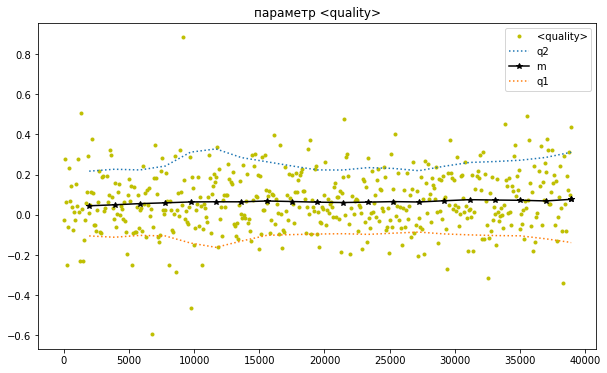

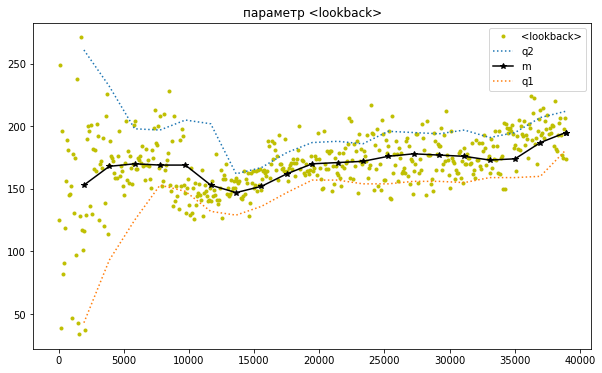

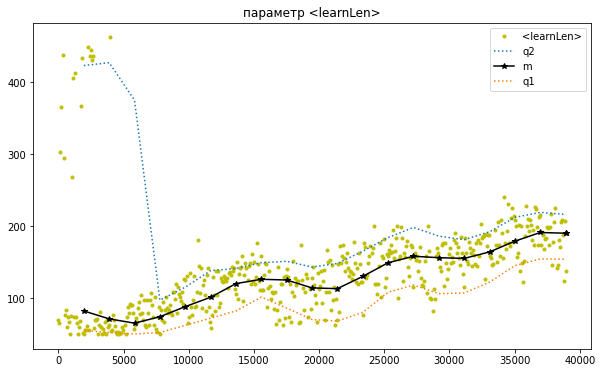

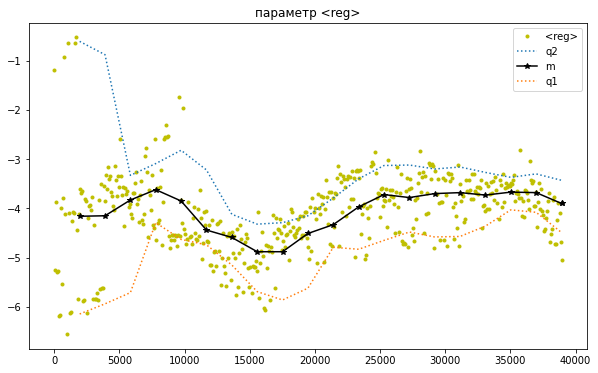

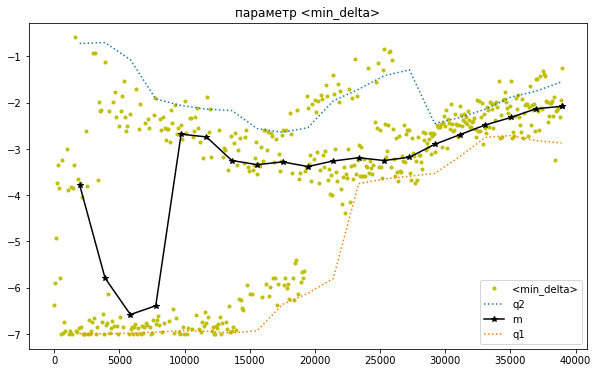

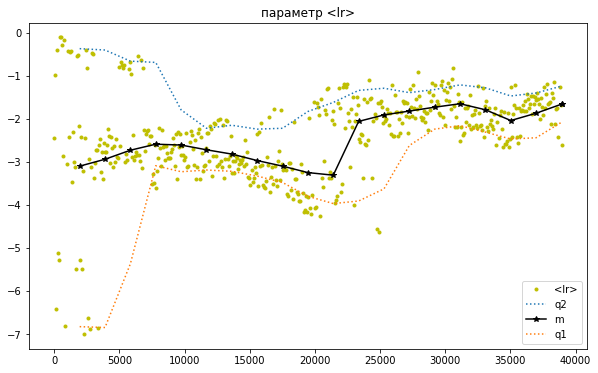

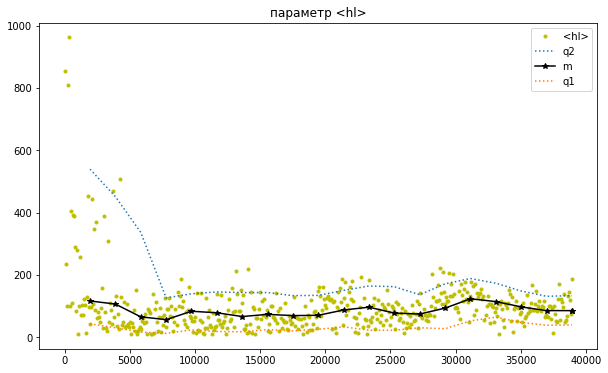

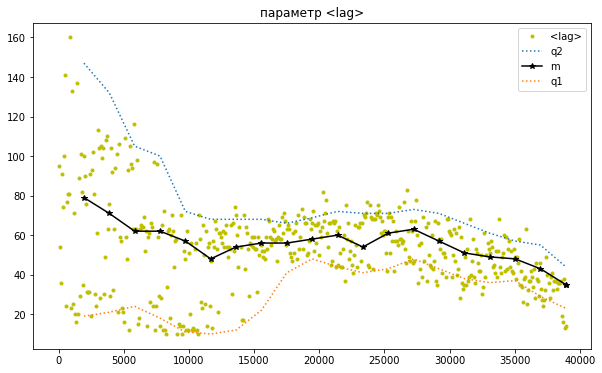

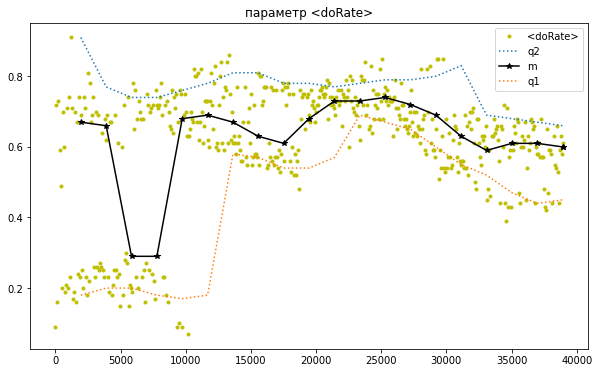

In [ ]:
modelGA.plot_hist_new(('quality','lookback','learnLen','reg','min_delta','lr','hl','lag','doRate'))


## Параметры лучшей

In [ ]:
best_par = modelGA.getBestParams()
best_par

{'doRate': 0.59,
 'hl': 94,
 'lag': 29,
 'learnLen': 185,
 'lookback': 193,
 'lr': -1.7200000000001125,
 'min_delta': -2.1000000000001044,
 'reg': -4.260000000000058}

# Прогон лучшей

In [ ]:
lookback_best = best_par['lookback']
lag_best = best_par['lag']
learnLen_best = best_par['learnLen']
reg_best = best_par['reg']
min_delta_best = best_par['min_delta']
lr_best = best_par['lr']
hl_best = best_par['hl']
doRate_best = best_par['doRate']

s_best = bt.Strategy('лучший', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best*2+learnLen_best+lookback_best+1),
                                bt.algos.SelectAll(),
                                WeighPredTF(lookback=lookback_best,
                                            learnLen=learnLen_best,
                                            reg=reg_best,
                                            min_delta=min_delta_best,
                                            lr=lr_best,
                                            hl=hl_best,
                                            lag=lag_best,
                                            doRate=doRate_best),
                                bt.algos.Rebalance()])
test_best = bt.Backtest(s_best, data)

s0 = bt.Strategy('равновесный', [bt.algos.RunEveryNPeriods(lag_best,offset=lag_best+learnLen_best+lookback_best+1),
                                 bt.algos.SelectAll(),
                                 bt.algos.WeighEqually(),
                                 bt.algos.Rebalance()])
test0 = bt.Backtest(s0, data)

res_best = bt.run(test_best,test0)

лучший
0% [############################# ] 100% | ETA: 00:00:07равновесный
0% [############################# ] 100% | ETA: 00:00:00

## График баланса

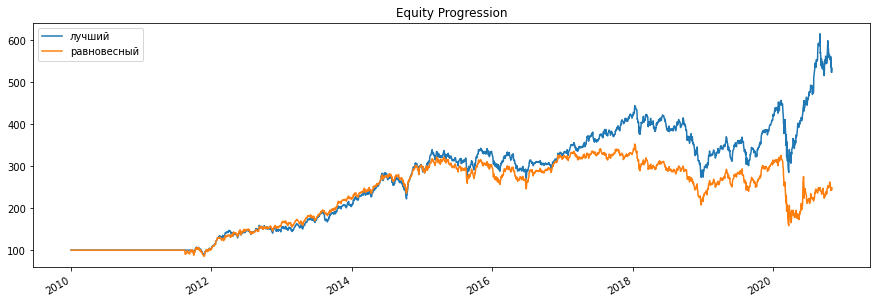

In [ ]:
res_best.plot()

## график распределения долей

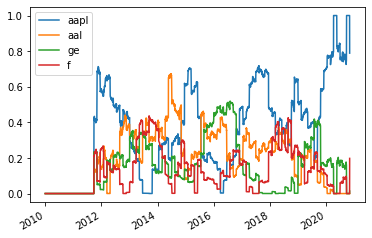

In [ ]:
res_best.get_security_weights().plot()

## график распределения свободной доли

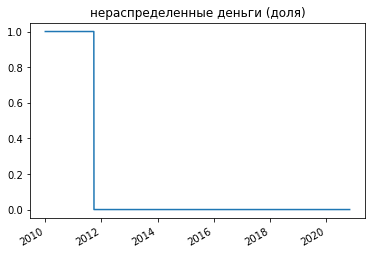

In [ ]:
w = res_best.get_weights(0)
w['деньги'] = 1-w.values[:,1:].sum(axis=1)
w['деньги'].plot()
plt.title('нераспределенные деньги (доля)')
del(w)

## итог

In [ ]:
res_best.display()

Stat                 лучший      равновесный
-------------------  ----------  -------------
Start                2010-01-03  2010-01-03
End                  2020-11-03  2020-11-03
Risk-free rate       0.00%       0.00%

Total Return         433.43%     148.24%
Daily Sharpe         0.79        0.47
Daily Sortino        1.26        0.74
CAGR                 16.71%      8.75%
Max Drawdown         -38.51%     -55.13%
Calmar Ratio         0.43        0.16

MTD                  1.71%       1.93%
3m                   2.00%       11.52%
6m                   44.69%      35.49%
YTD                  29.39%      -18.86%
1Y                   43.35%      -14.43%
3Y (ann.)            9.43%       -9.09%
5Y (ann.)            9.23%       -4.70%
10Y (ann.)           18.22%      9.52%
Since Incep. (ann.)  16.71%      8.75%

Daily Sharpe         0.79        0.47
Daily Sortino        1.26        0.74
Daily Mean (ann.)    18.08%      11.34%
Daily Vol (ann.)     22.86%      24.31%
Daily Skew           -0.15  

Енин А.В.

Оренбург